Перед вами датасет, описывающий поступление детей в колледж. Целевая переменная in_college


1. Осмотрите данные.
2. Примените для предобработки пайплайн с прошлого урока.
3. Решите задачу классификации методами:
    - логистической регрессии
    - линейной классификации
    - деревом решений
    - методом опорных векторов
4. Сравните полученные в каждом решении метрики между собой

Попробуйте использовать GridSearch для поиска оптимальных гиперпараметров, перечисленных выше алгоритмов.


In [1]:
import pickle
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, train_test_split,\
                                    cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy.stats import randint, uniform

In [2]:
df = pd.read_csv("data.csv")

Взглянем на датафрейм

In [3]:
df.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


Датафрейм содержит 1000 записей. Пропусков нет:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            1000 non-null   object 
 1   school_accreditation   1000 non-null   object 
 2   gender                 1000 non-null   object 
 3   interest               1000 non-null   object 
 4   residence              1000 non-null   object 
 5   parent_age             1000 non-null   int64  
 6   parent_salary          1000 non-null   int64  
 7   house_area             1000 non-null   float64
 8   average_grades         1000 non-null   float64
 9   parent_was_in_college  1000 non-null   bool   
 10  in_college             1000 non-null   bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 72.4+ KB


Взглянем на числовые и категориальные переменные

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parent_age,1000.0,5.220800e+01,3.500427e+00,40.0,5.000000e+01,52.000,5.400000e+01,65.0
parent_salary,1000.0,5.381570e+06,1.397546e+06,1000000.0,4.360000e+06,5440000.000,6.382500e+06,10000000.0
house_area,1000.0,7.451530e+01,1.529335e+01,20.0,6.460000e+01,75.500,8.482500e+01,120.0
average_grades,1000.0,8.609720e+01,3.378738e+00,75.0,8.373750e+01,85.575,8.826250e+01,98.0


In [6]:
for col in df.select_dtypes(include="object").columns:
    print(col, pd.unique(df[col]))

type_school ['Academic' 'Vocational']
school_accreditation ['A' 'B']
gender ['Male' 'Female']
interest ['Less Interested' 'Very Interested' 'Uncertain' 'Not Interested'
 'Quiet Interested']
residence ['Urban' 'Rural']


Cформируем перечни колонок в зависимости от типов.

In [7]:
numeric_features = df.select_dtypes(include=['int', 'float']).columns
categorical_features = df.select_dtypes(include=['object']).columns
bool_features = df.select_dtypes(include=['bool']).columns[:-1]
target = df.columns[-1]

Быстро оценим влияние параметров на целевую переменную

In [8]:
categorical_features

Index(['type_school', 'school_accreditation', 'gender', 'interest',
       'residence'],
      dtype='object')

In [9]:
df.groupby("type_school").aggregate({target: "mean"})

,in_college
type_school,
Academic,0.513957
Vocational,0.478261


In [10]:
df.groupby("school_accreditation").aggregate({target: "mean"})

,in_college
school_accreditation,
A,0.515593
B,0.485549


In [11]:
df.groupby("gender").aggregate({target: "mean"})

,in_college
gender,
Female,0.517526
Male,0.483495


In [12]:
df.groupby("interest").aggregate({target: "mean"}).sort_values(by=target)

,in_college
interest,
Quiet Interested,0.190000
Less Interested,0.379913
Not Interested,0.534884
Very Interested,0.586420
Uncertain,0.605364


In [13]:
df.groupby("residence").aggregate({target: "mean"})

,in_college
residence,
Rural,0.496746
Urban,0.502783


In [14]:
bool_features

Index(['parent_was_in_college'], dtype='object')

In [15]:
df.groupby("parent_was_in_college").aggregate({target: "mean"})

,in_college
parent_was_in_college,
False,0.475000
True,0.523077


Выводы:
1. Явной корреляции между категориальными принаками и таргетом нет... Почти везде распределение поступивших и не поступивших пополам.
2. Очень удивляет группировка по уровню интереса (к учёбе наверное). Не интересующиеся в среднем успешнее поступаю, чем очень интересующиеся.
Неуверенные обогнали всех.

Посмотрим на непрерывные переменные.

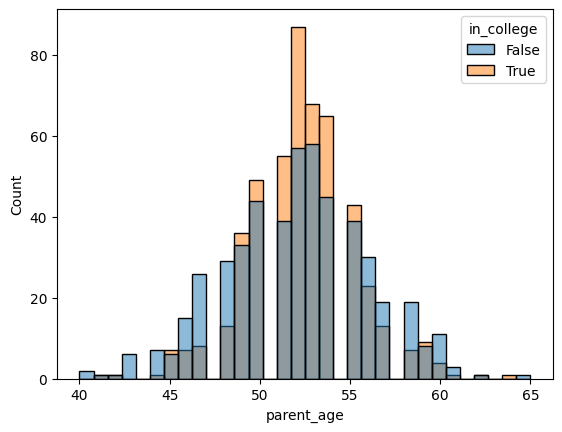

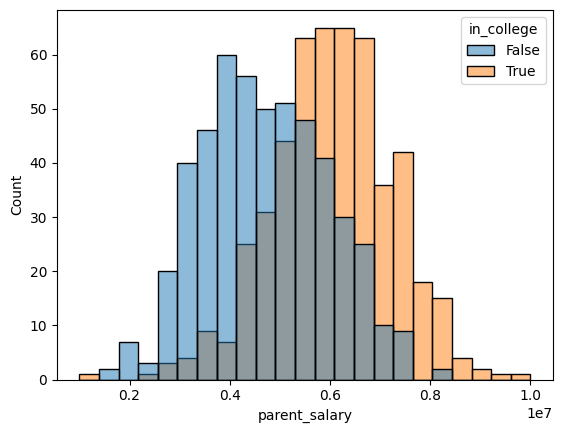

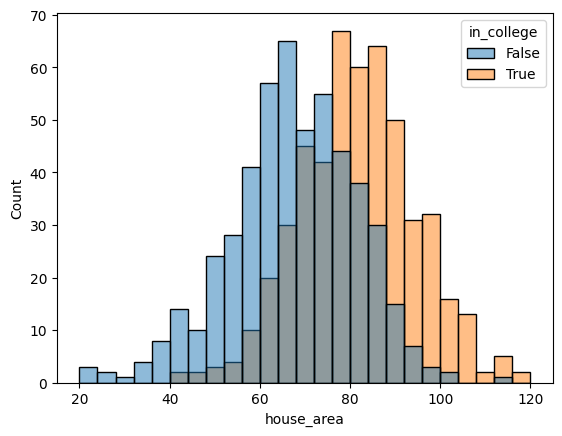

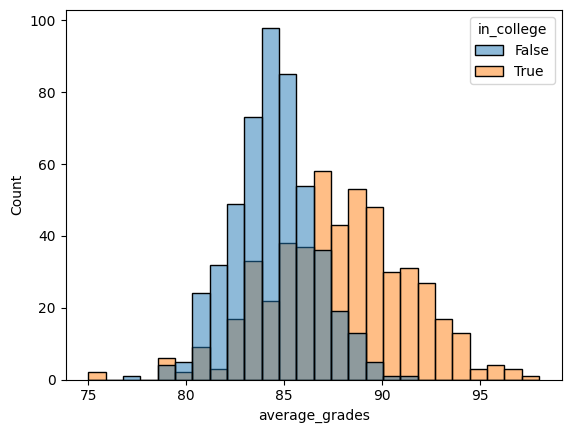

In [16]:
for feature in numeric_features:
    if feature != "in_college":
        sns.histplot(data=df, x=feature, hue="in_college")
        plt.show()

Выводы:
1. Зависимости между возрастом родителей и успешностью поступления нет на мой взгляд.
2. А вот между состоятельностью семьи, а также набранными балами - есть (очевидная).

Отделим от датафрейма 10% для валидации. К большей части приеним кросс-валидацию

In [17]:
df, df_val = train_test_split(df, train_size=0.9, random_state=0)

df.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)

df_val.to_csv("data_val.csv", index=False)

Преобразуем логические колонки в числа.

In [18]:
df[df.select_dtypes(include="bool").columns] = \
    df[df.select_dtypes(include="bool").columns].astype("int")

Сделаем пайплайн, который будет делать скаллирование числовых и обработку категориальных переменных. Бинарные признаки и таргет обрабатывать не нужно

In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

Данный препроцессор будет скалировать чиловые переменные StandardScaler, предварительно заменив пропуски медианным значением.
Категориальные переменные обработает OneHotEncoder со стратегией "игнорировать" неизвестную категорию

In [20]:
x_train = df.drop([target], axis=1)
y_train = df[target]

In [21]:
x_train = preprocessor.fit_transform(x_train)

Сохраним препроцессор

In [22]:
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

C помощью RandomizedSearchCV определим наилучшие параметры для моделей

Логистическая регрессия:

In [23]:
param_distributions = {"penalty": ["l1", "l2", "elasticnet"],
                       "C": randint(1, 101)}

log_search = RandomizedSearchCV(estimator=LogisticRegression(random_state=0),
                             param_distributions=param_distributions,
                             n_iter=50,
                             random_state=0)

log_search.fit(x_train, y_train)
log_search.best_params_

c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
175 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Николай\AppData\Local\Pro

{'C': 45, 'penalty': 'l2'}

Больно много ругается... Возможно, он не попрбовал все предложенные гиперпараметры, но тем не менее

In [24]:
log_clf = log_search.best_estimator_
log_score = cross_val_score(log_clf, x_train, y_train, cv=5, scoring='roc_auc')
log_score.mean(), log_score.std()

(0.9297753205318748, 0.0237072735211128)

Линейный классификатор:

In [25]:
param_distributions = {"penalty": ["l1", "l2", "elasticnet"],
                       "loss": ["hinge", "log_loss", "modified_huber", 
                                "squared_hinge", "perceptron", "squared_error", 
                                "huber", "epsilon_insensitive", "squared_epsilon_insensitive"],
                        "alpha": uniform(0, 1)}

lin_search = RandomizedSearchCV(estimator=SGDClassifier(random_state=0),
                             param_distributions=param_distributions,
                             n_iter=50,
                             random_state=0)

lin_search.fit(x_train, y_train)
lin_search.best_params_

c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence

{'alpha': 0.06414749634878436,
 'loss': 'modified_huber',
 'penalty': 'elasticnet'}

Этому тоже не хватило итераций. Много предупреждений. Но тем не менее, объект получен

In [26]:
lin_clf = lin_search.best_estimator_
lin_score = cross_val_score(lin_clf, x_train, y_train, cv=5, scoring='roc_auc')
lin_score.mean(), lin_score.std()

(0.9289849775692472, 0.022297111853667475)

Дерево решений:

In [27]:
param_distributions = {"criterion": ["gini", "entropy", "log_loss"],
                       "splitter": ["best", "random"],
                       "max_depth": randint(2, 20),
                       "min_samples_split": randint(2, 10),
                       "min_samples_leaf": randint(2, 10),
                       "max_leaf_nodes": randint(2, 10),
                       "max_features": ["sqrt", "log2"]}

tree_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                             param_distributions=param_distributions,
                             n_iter=500,
                             random_state=0)

tree_search.fit(x_train, y_train)
tree_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 6,
 'min_samples_split': 5,
 'splitter': 'best'}

In [28]:
tree_clf = tree_search.best_estimator_
tree_score = cross_val_score(tree_clf, x_train, y_train, cv=5, scoring='roc_auc')
tree_score.mean(), tree_score.std()

(0.8255843672210714, 0.04354209771950886)

Метод опорных векторов:

In [29]:
param_distributions = {"degree": randint(1, 10),
                       "kernel": ["linear", "poly", "rbf", "sigmoid"],
                       "C": randint(1, 101)}

svm_search = RandomizedSearchCV(estimator=SVC(random_state=0),
                             param_distributions=param_distributions,
                             n_iter=50,
                             random_state=0)

svm_search.fit(x_train, y_train)
svm_search.best_params_

{'C': 3, 'degree': 3, 'kernel': 'rbf'}

In [30]:
svm_clf = svm_search.best_estimator_
svm_score = cross_val_score(svm_clf, x_train, y_train, cv=5, scoring='roc_auc')
svm_score.mean(), svm_score.std()

(0.9749127266131012, 0.006549633573113733)

ROC-score вышел наилучшим у svm-классификатора с параметрами {'C': 3, 'degree': 3, 'kernel': 'rbf'}. Запиклим его

In [31]:
with open('classifier.pkl', 'wb') as f:
    pickle.dump(svm_clf, f)

Имитируем переход на другой компьютер. Для этого убьем ядро и сотрем все переменные.

In [32]:
os._exit(00)

: 

: 

In [1]:
import pickle

import pandas as pd

from sklearn.metrics import roc_auc_score, confusion_matrix, \
                            precision_score, recall_score, f1_score

Прочитаем объекты препроцессор и классификатор.

In [2]:
with open('preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

with open('classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)

In [3]:
df = pd.read_csv("data_val.csv")

In [4]:
df.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,B,Male,Very Interested,Rural,53,5000000,50.8,84.54,True,False
1,Academic,A,Male,Less Interested,Rural,49,6770000,81.0,83.70,False,False
2,Vocational,A,Female,Less Interested,Rural,44,8370000,65.3,83.54,False,False
3,Academic,B,Male,Very Interested,Urban,56,5910000,91.3,85.29,False,True
4,Academic,B,Male,Not Interested,Rural,50,6050000,107.5,85.46,True,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            100 non-null    object 
 1   school_accreditation   100 non-null    object 
 2   gender                 100 non-null    object 
 3   interest               100 non-null    object 
 4   residence              100 non-null    object 
 5   parent_age             100 non-null    int64  
 6   parent_salary          100 non-null    int64  
 7   house_area             100 non-null    float64
 8   average_grades         100 non-null    float64
 9   parent_was_in_college  100 non-null    bool   
 10  in_college             100 non-null    bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 7.4+ KB


Снова определим перечни колонокам по типам данных.

In [6]:
numeric_features = df.select_dtypes(include=['int', 'float']).columns
categorical_features = df.select_dtypes(include=['object']).columns
bool_features = df.select_dtypes(include=['bool']).columns[:-1]
target = df.columns[-1]

Преобразуем bool -> int

In [7]:
df[df.select_dtypes(include="bool").columns] = \
    df[df.select_dtypes(include="bool").columns].astype("int")

Отделим таргет от датафрейма

In [8]:
x_test = df.drop([target], axis=1)
y_test = df[target]

Обработаем тестовую выборку препроцессором

In [9]:
x_test = preprocessor.transform(x_test)

Сделаем предикт на обученном классификаторе

In [10]:
y_pred = classifier.predict(x_test)

In [11]:
roc_auc_score(y_test, y_pred)

0.8701923076923077

In [12]:
confusion_matrix(y_test, y_pred)

array([[45,  7],
       [ 6, 42]], dtype=int64)

In [13]:
precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.8571428571428571, 0.875, 0.8659793814432989)